In [52]:
import xgboost as xgb
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBClassifier
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

In [13]:
train_basic_fuzzy = pd.read_csv('train_basic_fuzzy_new.csv', sep=',')
train_w2v = pd.read_csv('train_w2v_feats.csv', sep=',')

In [14]:
print train_basic_fuzzy.columns
print train_basic_fuzzy.shape
print train_w2v.columns
print train_w2v.shape

Index([u'id', u'is_duplicate', u'question1_form', u'question2_form',
       u'q1_form_len', u'q2_form_len', u'q1_length', u'q2_length',
       u'q1_unique', u'q2_unique', u'q1_form_uni', u'q2_form_uni',
       u'q1_form_char', u'q2_form_char', u'q1_q2_char_diff', u'common_cnt',
       u'prcnt_common', u'partial_ratio', u'partial_token_set_ratio',
       u'partial_token_sort_ratio', u'q_ratio', u'token_set_ratio',
       u'token_sort_ratio', u'w_ratio'],
      dtype='object')
(404290, 24)
Index([u'id', u'is_duplicate', u'q1_freq_in_q1', u'q2_freq_in_q2',
       u'q1_freq_in_q1q2', u'q2_freq_in_q1q2', u'cosine_val', u'cityblock_val',
       u'jaccard_val', u'canberra_val', u'euclidean_val', u'minkowski_val',
       u'braycurtis_val', u'skew_que1', u'skew_que2', u'kurt_que1',
       u'kurt_que2'],
      dtype='object')
(404290, 17)


In [15]:
train_basic_fuzzy.drop(['question1_form','question2_form'], axis=1, inplace=True)

In [16]:
# Join both the dataframes train_basic_fuzzy and train_w2v on 'id' column
train_final = pd.merge(train_w2v, train_basic_fuzzy, left_on=['id','is_duplicate'],right_on=['id','is_duplicate'],how='inner', right_index=False)
print train_final.columns

Index([u'id', u'is_duplicate', u'q1_freq_in_q1', u'q2_freq_in_q2',
       u'q1_freq_in_q1q2', u'q2_freq_in_q1q2', u'cosine_val', u'cityblock_val',
       u'jaccard_val', u'canberra_val', u'euclidean_val', u'minkowski_val',
       u'braycurtis_val', u'skew_que1', u'skew_que2', u'kurt_que1',
       u'kurt_que2', u'q1_form_len', u'q2_form_len', u'q1_length',
       u'q2_length', u'q1_unique', u'q2_unique', u'q1_form_uni',
       u'q2_form_uni', u'q1_form_char', u'q2_form_char', u'q1_q2_char_diff',
       u'common_cnt', u'prcnt_common', u'partial_ratio',
       u'partial_token_set_ratio', u'partial_token_sort_ratio', u'q_ratio',
       u'token_set_ratio', u'token_sort_ratio', u'w_ratio'],
      dtype='object')


In [17]:
# Check the feature values for any kind of imputation
train_final.count()

id                          404290
is_duplicate                404290
q1_freq_in_q1               404290
q2_freq_in_q2               404290
q1_freq_in_q1q2             404290
q2_freq_in_q1q2             404290
cosine_val                  404290
cityblock_val               404290
jaccard_val                 404290
canberra_val                404290
euclidean_val               404290
minkowski_val               404290
braycurtis_val              404290
skew_que1                   404290
skew_que2                   404290
kurt_que1                   404290
kurt_que2                   404290
q1_form_len                 404290
q2_form_len                 404290
q1_length                   404290
q2_length                   404290
q1_unique                   404290
q2_unique                   404290
q1_form_uni                 404290
q2_form_uni                 404290
q1_form_char                404290
q2_form_char                404290
q1_q2_char_diff             404290
common_cnt          

In [18]:
val_dup = train_final["is_duplicate"]
train_final.drop(['id','is_duplicate'], axis=1, inplace=True)

In [19]:
val_dup = pd.DataFrame(pd.Series(val_dup))

In [20]:
# Separate into Train and Validation
import random
random.seed(45)
from sklearn.cross_validation import train_test_split
X_train, X_val, Y_train, Y_val = sklearn.cross_validation.train_test_split(train_final, val_dup, 
                                                                           test_size = 0.2, random_state = 5)

In [21]:
# xgboost fn
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=Y_train[[0]].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics=['logloss'], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(dtrain[predictors], np.ravel(Y_train),eval_metric='logloss')     #Fit algorithm

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    print("AUC Score (Train): %f" % roc_auc_score(np.ravel(Y_train), dtrain_predprob))
    print("Log Loss (Train): %f " % log_loss(np.ravel(Y_train), dtrain_predprob))
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [22]:
# xgboost classifier : Using the best params from the Basic Features Model
xgb_log1 = XGBClassifier(max_depth= 6, min_child_weight= 1,gamma=0.2, colsample_bytree=0.8, subsample=0.7, reg_alpha = 1, 
                     reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 1, learning_rate = 0.05, n_estimators=700,
                     objective= 'binary:logistic', nthread=4, seed=45)

AUC Score (Train): 0.933969
Log Loss (Train): 0.312020 


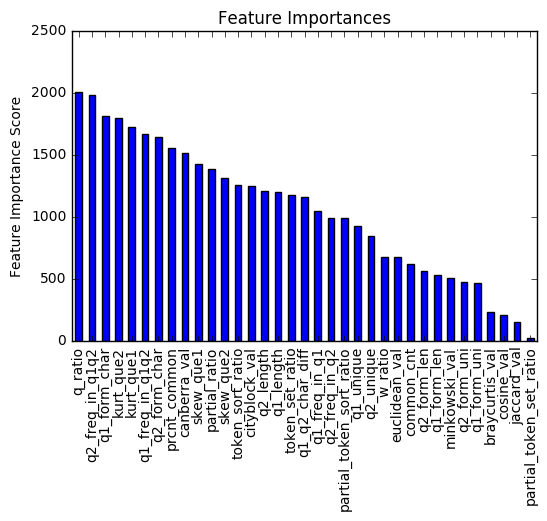

In [54]:
predictors  = list(X_train.columns)
modelfit(xgb_log1, X_train, predictors)

In [25]:
# Train log_loss
y_predS = xgb_log1.predict_proba(X_train)
log_loss(Y_train, y_predS[:,1])

0.31202009100336681

In [34]:
# Cross validation AUC & log_loss
cv_score = cross_val_score(xgb_log1, X_train, np.ravel(Y_train), cv = 5, scoring ='roc_auc')
print('mean auc: ' + str(cv_score.mean()))
print('std auc: ' + str(cv_score.std()))
cv_score1 = cross_val_score(xgb_log1, X_train, np.ravel(Y_train), cv = 5, scoring ='log_loss')
print 'mean log_loss: ' + str(cv_score1.mean())
print 'std log_loss: ' + str(cv_score1.std())

mean auc: 0.920922330527
std auc: 0.000976073300935
mean log_loss: -0.337568262157
std log_loss: 0.00187927608511


In [28]:
# Save the model
from sklearn.externals import joblib
joblib.dump(xgb_log1, '/home/pgoyal/quora/model4/xgb_log1_dup_logloss.pkl')

['/home/pgoyal/quora/model4/xgb_log1_dup_logloss.pkl',
 '/home/pgoyal/quora/model4/xgb_log1_dup_logloss.pkl_01.npy']

In [29]:
# Validation AUC
val_pred = xgb_log1.predict_proba(X_val)
print('Validation AUC: ' + str(roc_auc_score(Y_val, val_pred[:,1])))
print 'Validation log_loss: ' + str(log_loss(Y_val, val_pred[:,1]))

Validation AUC: 0.92212199021
Validation log_loss: 0.334761542362


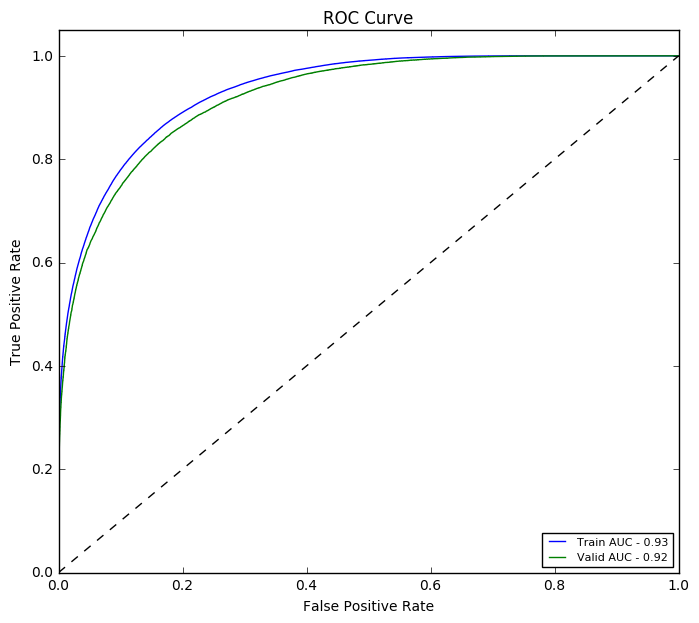

In [30]:
# Make ROC curve for train and validation
from sklearn.metrics import roc_curve, auc

fpr_trn, tpr_trn, _= roc_curve(Y_train, y_predS[:,1])
fpr_tst, tpr_tst, _= roc_curve(Y_val, val_pred[:, 1]) 

roc_auc_trn = auc(fpr_trn, tpr_trn)
roc_auc_tst = auc(fpr_tst, tpr_tst)

# Plot of a ROC curve
plt.figure(figsize=(8,7))
plt.plot(fpr_trn, tpr_trn, label='Train AUC - %0.2f' % roc_auc_trn)
plt.plot(fpr_tst, tpr_tst, label='Valid AUC - %0.2f' % roc_auc_tst)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={'size':8})
# plt.savefig('ROC_Curve.png')

In [31]:
from sklearn import cross_validation
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV

In [32]:
# Initial set of parameters are taken from the final set of params from the Grid Search on the XGB log-loss of basic and fuzzy features
ini_max_depth = 6
ini_min_child_weight= 1
ini_gamma= 0.2
ini_colsample_bytree=0.8
ini_subsample= 0.7
ini_reg_alpha =1
ini_reg_lambda =0
ini_max_delta_step= 3
ini_scale_pos_weight=1
ini_learning_rate = 0.05
ini_n_estimators = 700

In [35]:
# Tune tree pruning parameters: max_depth and min_child_weight
param_test1 = {
   'max_depth':[ 4, 5,6,7],
   'min_child_weight':[1, 2, 3, 5, 6]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test1, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/quora/model4/gs_files/gs_search1.csv')
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.34359, std: 0.00160, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -0.34357, std: 0.00160, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: -0.34352, std: 0.00171, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -0.34354, std: 0.00167, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -0.34365, std: 0.00169, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -0.34000, std: 0.00178, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.34020, std: 0.00177, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: -0.34024, std: 0.00176, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.34032, std: 0.00175, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.34027, std: 0.00171, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: -0.33757, std: 0.00188, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: -0.33773, std: 0.00174, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: -0.33764, std: 0.001

In [36]:
# Best till here : Order is on the basis of the params given!
ini_max_depth = gsearch1.best_params_.values()[0]
ini_min_child_weight = gsearch1.best_params_.values()[1]

In [37]:
# Tune tree pruning parameters: gamma
param_test2 = {
   'gamma':[i/10.0 for i in range(0,4)]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test2, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch2.grid_scores_).to_csv('/home/pgoyal/quora/model4/gs_files/gs_search2.csv')
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -0.33564, std: 0.00192, params: {'gamma': 0.0},
  mean: -0.33574, std: 0.00192, params: {'gamma': 0.1},
  mean: -0.33578, std: 0.00186, params: {'gamma': 0.2},
  mean: -0.33573, std: 0.00182, params: {'gamma': 0.3}],
 {'gamma': 0.0},
 -0.33563911361257137)

In [38]:
# Best till here :
ini_gamma = gsearch2.best_params_.values()[0]

In [39]:
# Tune tree pruning parameters: subsample, colsample_bytree
param_test3 = {
  'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test3, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch3.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch3.grid_scores_).to_csv('/home/pgoyal/quora/model4/gs_files/gs_search3.csv')
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -0.33607, std: 0.00181, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -0.33581, std: 0.00182, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -0.33553, std: 0.00186, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -0.33516, std: 0.00178, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: -0.33625, std: 0.00169, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: -0.33560, std: 0.00169, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -0.33527, std: 0.00187, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: -0.33525, std: 0.00168, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: -0.33628, std: 0.00205, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: -0.33564, std: 0.00192, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: -0.33554, std: 0.00186, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: -0.33551, std: 0.00173, params: {'subsample': 0.9, 'colsa

In [40]:
# Best till here :
ini_subsample = gsearch3.best_params_.values()[0]
ini_colsample_bytree = gsearch3.best_params_.values()[1]

In [41]:
# Tune tree pruning parameters: reg_alpha
param_test4 = {
    'reg_alpha':[ 1e-2, 0.1, 1, 1.1]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test4, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch4.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch4.grid_scores_).to_csv('/home/pgoyal/quora/model4/gs_files/gs_search4.csv')
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -0.33566, std: 0.00144, params: {'reg_alpha': 0.01},
  mean: -0.33553, std: 0.00182, params: {'reg_alpha': 0.1},
  mean: -0.33516, std: 0.00178, params: {'reg_alpha': 1},
  mean: -0.33516, std: 0.00171, params: {'reg_alpha': 1.1}],
 {'reg_alpha': 1},
 -0.33515614784559311)

In [42]:
# Best till here :
ini_reg_alpha= gsearch4.best_params_.values()[0]

In [43]:
# Tune tree pruning parameters: reg_lambda
param_test5 = {
  'reg_lambda':[0, 1,2, 3]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test5, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch5.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch5.grid_scores_).to_csv('/home/pgoyal/quora/model4/gs_files/gs_search5.csv')
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: -0.33516, std: 0.00178, params: {'reg_lambda': 0},
  mean: -0.33551, std: 0.00172, params: {'reg_lambda': 1},
  mean: -0.33547, std: 0.00157, params: {'reg_lambda': 2},
  mean: -0.33550, std: 0.00173, params: {'reg_lambda': 3}],
 {'reg_lambda': 0},
 -0.33515614784559311)

In [44]:
# Best till here :
ini_reg_lambda= gsearch5.best_params_.values()[0]

In [45]:
# Tune tree pruning parameters: max_delta_step
param_test6 = {
  'max_delta_step':[1,2,3,4]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test6, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch6.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch6.grid_scores_).to_csv('/home/pgoyal/quora/model4/gs_files/gs_search6.csv')
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: -0.33578, std: 0.00187, params: {'max_delta_step': 1},
  mean: -0.33533, std: 0.00184, params: {'max_delta_step': 2},
  mean: -0.33516, std: 0.00178, params: {'max_delta_step': 3},
  mean: -0.33523, std: 0.00167, params: {'max_delta_step': 4}],
 {'max_delta_step': 3},
 -0.33515614784559311)

In [46]:
# Best till here :
ini_max_delta_step= gsearch6.best_params_.values()[0]

In [47]:
# Tune tree pruning parameters: scale_pos_weight
param_test7 = {
  'scale_pos_weight':[1, 2, 4]
}

gsearch7 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test7, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch7.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch7.grid_scores_).to_csv('/home/pgoyal/quora/model4/gs_files/gs_search7.csv')
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: -0.33516, std: 0.00178, params: {'scale_pos_weight': 1},
  mean: -0.35756, std: 0.00126, params: {'scale_pos_weight': 2},
  mean: -0.42525, std: 0.00128, params: {'scale_pos_weight': 4}],
 {'scale_pos_weight': 1},
 -0.33515614784559311)

In [48]:
# Best till here :
ini_scale_pos_weight= gsearch7.best_params_.values()[0]

In [49]:
param_test8 = {
    'learning_rate':[0.01, 0.03, 0.05],
    'n_estimators':[250, 500, 650, 800]
}

gsearch8 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test8, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch8.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch8.grid_scores_).to_csv('/home/pgoyal/quora/model4/gs_files/gs_search8.csv')
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: -0.37619, std: 0.00101, params: {'n_estimators': 250, 'learning_rate': 0.01},
  mean: -0.35193, std: 0.00120, params: {'n_estimators': 500, 'learning_rate': 0.01},
  mean: -0.34795, std: 0.00131, params: {'n_estimators': 650, 'learning_rate': 0.01},
  mean: -0.34540, std: 0.00135, params: {'n_estimators': 800, 'learning_rate': 0.01},
  mean: -0.34621, std: 0.00132, params: {'n_estimators': 250, 'learning_rate': 0.03},
  mean: -0.33975, std: 0.00147, params: {'n_estimators': 500, 'learning_rate': 0.03},
  mean: -0.33789, std: 0.00151, params: {'n_estimators': 650, 'learning_rate': 0.03},
  mean: -0.33662, std: 0.00152, params: {'n_estimators': 800, 'learning_rate': 0.03},
  mean: -0.34119, std: 0.00145, params: {'n_estimators': 250, 'learning_rate': 0.05},
  mean: -0.33667, std: 0.00155, params: {'n_estimators': 500, 'learning_rate': 0.05},
  mean: -0.33548, std: 0.00167, params: {'n_estimators': 650, 'learning_rate': 0.05},
  mean: -0.33471, std: 0.00185, params: {'n_estimators

In [50]:
# Best till here :
ini_n_estimators= gsearch8.best_params_.values()[0]
ini_learning_rate= gsearch8.best_params_.values()[1]

In [51]:
print "max_depth", ini_max_depth
print "min_child_weight", ini_min_child_weight
print "gamma", ini_gamma
print "colsample_bytree", ini_colsample_bytree
print "subsample", ini_subsample
print "reg_alpha", ini_reg_alpha
print "reg_lambda", ini_reg_lambda
print "max_delta_step", ini_max_delta_step
print "scale_pos_weight", ini_scale_pos_weight
print "learning_rate", ini_learning_rate
print "n_estimators", ini_n_estimators

max_depth 7
min_child_weight 1
gamma 0.0
colsample_bytree 0.6
subsample 0.9
reg_alpha 1
reg_lambda 0
max_delta_step 3
scale_pos_weight 1
learning_rate 0.05
n_estimators 800


Will train until cv error hasn't decreased in 50 rounds.


AUC Score (Train): 0.944532
Log Loss (Train): 0.290844 


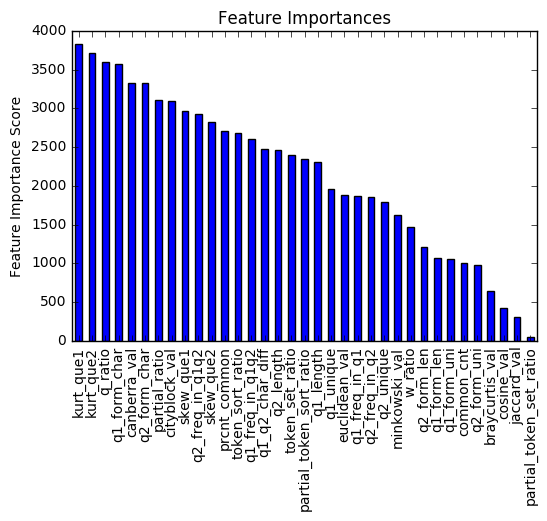

In [53]:
# xgboost classifier Using the param values till param8 from the above GridSearch
xgb_log2 = XGBClassifier(max_depth= 7, min_child_weight= 1, gamma=0.0, colsample_bytree=0.6, subsample=0.9, 
                    reg_alpha = 1, reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 1, learning_rate = 0.05, 
                    n_estimators=800, objective= 'binary:logistic', nthread=4, seed=45)

#Choose the predictors for xgboost and fit the model
modelfit(xgb_log2, X_train, predictors)

In [55]:
# Train roc_auc & Log Loss
y_predS_xgb_log2 = xgb_log2.predict_proba(X_train)
print('Validation AUC: ' + str( roc_auc_score(Y_train, y_predS_xgb_log2[:,1]) ))
print('Validation LogLoss: ' + str( log_loss(Y_train, y_predS_xgb_log2[:,1]) ))

Validation AUC: 0.944532489467
Validation LogLoss: 0.290844450225


In [57]:
# Cross validation AUC 
cv_score_xgb_log2 = cross_val_score(xgb_log2, X_train, np.ravel(Y_train), cv = 5, scoring ='roc_auc')
print('mean auc: ' + str(cv_score_xgb_log2.mean()))
print('std auc: ' + str(cv_score_xgb_log2.std()))
cv_score1_xgb_log2 = cross_val_score(xgb_log2, X_train, np.ravel(Y_train), cv = 5, scoring ='log_loss')
print 'mean log_loss: ' + str(cv_score1_xgb_log2.mean())
print 'std log_loss: ' + str(cv_score1_xgb_log2.std())

mean auc: 0.922296553918
std auc: 0.000937057748154
mean log_loss: -0.334712248577
std log_loss: 0.00184750438831


In [56]:
# Save the model# Model with prcnt_common feature
from sklearn.externals import joblib
joblib.dump(xgb_log2, '/home/pgoyal/quora/model4/xgb_log2_dup_logloss.pkl')

['/home/pgoyal/quora/model4/xgb_log2_dup_logloss.pkl',
 '/home/pgoyal/quora/model4/xgb_log2_dup_logloss.pkl_01.npy']

### Further Grid Search

In [75]:
param_test9 = {
    'max_depth' : [6,7,8,9],
    'colsample_bytree' : [i/10.0 for i in range(3,7)],
    'subsample' : [i/10.0 for i in range(8,11)],
    'n_estimators':[750, 800, 850, 900,950,100]
}

gsearch9 = GridSearchCV(estimator = XGBClassifier(max_depth= 7, min_child_weight= 1,
                    gamma=0.0, colsample_bytree=0.6, subsample=0.9, 
                    reg_alpha = 1, reg_lambda = 1, max_delta_step = 3, 
                    scale_pos_weight= 1, learning_rate = 0.05, 
                    n_estimators=800, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test9, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch9.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch9.grid_scores_).to_csv('/home/pgoyal/quora/model4/gs_files/gs_search9.csv')
gsearch9.grid_scores_, gsearch9.best_params_, gsearch9.best_score_

[mean: -0.33972, std: 0.00164, params:
{'n_estimators': 750, 'subsample': 0.8,
'colsample_bytree': 0.3, 'max_depth':
6},
mean: -0.33953, std: 0.00138, params:
{'n_estimators': 750, 'subsample': 0.9,
'colsample_bytree': 0.3, 'max_depth':
6},
mean: -0.33937, std: 0.00160, params:
{'n_estimators': 750, 'subsample': 1.0,
'colsample_bytree': 0.3, 'max_depth':
6},
mean: -0.33934, std: 0.00163, params:
{'n_estimators': 800, 'subsample': 0.8,
'colsample_bytree': 0.3, 'max_depth':
6},
mean: -0.33912, std: 0.00141, params:
{'n_estimators': 800, 'subsample': 0.9,
'colsample_bytree': 0.3, 'max_depth':
6},
mean: -0.33899, std: 0.00160, params:
{'n_estimators': 800, 'subsample': 1.0,
'colsample_bytree': 0.3, 'max_depth':
6},
mean: -0.33900, std: 0.00163, params:
{'n_estimators': 850, 'subsample': 0.8,
'colsample_bytree': 0.3, 'max_depth':
6},
mean: -0.33871, std: 0.00145, params:
{'n_estimators': 850, 'subsample': 0.9,
'colsample_bytree': 0.3, 'max_depth':
6},
mean: -0.33864, std: 0.00158, params:
{

In [76]:
# Best till here :
ini_n_estimators= gsearch9.best_params_.values()[0]
ini_subsample= gsearch9.best_params_.values()[1]
ini_colsample_bytree= gsearch9.best_params_.values()[2]
ini_max_depth= gsearch9.best_params_.values()[3]

In [77]:
print "max_depth", ini_max_depth
print "min_child_weight", ini_min_child_weight
print "gamma", ini_gamma
print "colsample_bytree", ini_colsample_bytree
print "subsample", ini_subsample
print "reg_alpha", ini_reg_alpha
print "reg_lambda", ini_reg_lambda
print "max_delta_step", ini_max_delta_step
print "scale_pos_weight", ini_scale_pos_weight
print "learning_rate", ini_learning_rate
print "n_estimators", ini_n_estimators

max_depth 9
min_child_weight 1
gamma 0.0
colsample_bytree 0.6
subsample 0.9
reg_alpha 1
reg_lambda 0
max_delta_step 3
scale_pos_weight 1
learning_rate 0.05
n_estimators 750


Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[652] cv-mean:0.334182	cv-std:0.00320728439649


AUC Score (Train): 0.963605
Log Loss (Train): 0.250765 


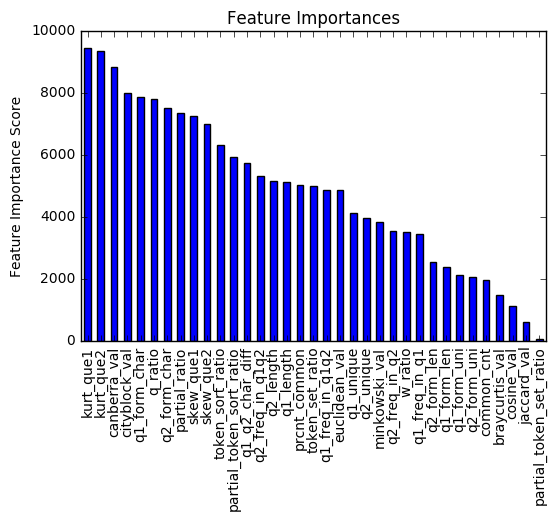

In [78]:
# xgboost classifier Using the param values till param9 from the above GridSearch
xgb_log2b = XGBClassifier(max_depth= 9, min_child_weight= 1, gamma=0.0, colsample_bytree=0.6, subsample=0.9, 
                    reg_alpha = 1, reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 1, learning_rate = 0.05, 
                    n_estimators=750, objective= 'binary:logistic', nthread=4, seed=45)

#Choose the predictors for xgboost and fit the model
modelfit(xgb_log2b, X_train, predictors)

In [79]:
# Train roc_auc & Log Loss
y_predS_xgb_log2b = xgb_log2b.predict_proba(X_train)
print('Validation AUC: ' + str( roc_auc_score(Y_train, y_predS_xgb_log2b[:,1]) ))
print('Validation LogLoss: ' + str( log_loss(Y_train, y_predS_xgb_log2b[:,1]) ))

Validation AUC: 0.963604523398
Validation LogLoss: 0.250765183511


In [80]:
# Save the model# Model with prcnt_common feature
from sklearn.externals import joblib
joblib.dump(xgb_log2b, '/home/pgoyal/quora/model4/xgb_log2b_dup_logloss.pkl')

['/home/pgoyal/quora/model4/xgb_log2b_dup_logloss.pkl',
 '/home/pgoyal/quora/model4/xgb_log2b_dup_logloss.pkl_01.npy']

In [98]:
# Cross validation AUC 
cv_score_xgb_log2b = cross_val_score(xgb_log2b, X_train, np.ravel(Y_train), cv = 5, scoring ='roc_auc')
print('mean auc: ' + str(cv_score_xgb_log2b.mean()))
print('std auc: ' + str(cv_score_xgb_log2b.std()))
cv_score1_xgb_log2b = cross_val_score(xgb_log2b, X_train, np.ravel(Y_train), cv = 5, scoring ='log_loss')
print 'mean log_loss: ' + str(cv_score1_xgb_log2b.mean())
print 'std log_loss: ' + str(cv_score1_xgb_log2b.std())

mean auc: 0.922763106582
std auc: 0.000838071956686
mean log_loss: -0.333654868156
std log_loss: 0.00179751688934


## Decile Info - Train

In [81]:
# Decile related info

df_list = [1,2,3,4,5,6,7,8,9,10]

prob = pd.DataFrame(y_predS_xgb_log2b[:,1]) # y_predS is to be changed
prob.columns = ['Probability']
prob["Target"] = Y_train.values # y_train to be changed
prob = prob.sort_values(by='Probability', ascending=0)

dec = int(prob['Target'].shape[0]/10)

for i in [0,1,2,3,4,5,6,7,8,9]:
    vars()['dec_'+str(df_list[i])+'_rr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(dec))
    vars()['dec_'+str(df_list[i])+'_cr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(prob['Target'].sum()))
    vars()['dec_'+str(df_list[i])+'_goods'] = float(prob['Target'][i*dec:(i+1)*dec].sum())
    vars()['dec_'+str(df_list[i])+'_bads'] = float(prob['Target'][i*dec:(i+1)*dec].count())-float(
        prob['Target'][i*dec:(i+1)*dec].sum())

decile_num = pd.DataFrame([dec, dec, dec, dec, dec, dec, dec, dec, dec, dec], columns = ['# decile'])
decile_goods = pd.DataFrame([dec_1_goods, dec_2_goods, dec_3_goods, dec_4_goods, dec_5_goods, dec_6_goods, dec_7_goods,
                          dec_8_goods, dec_9_goods, dec_10_goods], columns = ['# of goods'])
decile_bads = pd.DataFrame([dec_1_bads, dec_2_bads, dec_3_bads, dec_4_bads, dec_5_bads, dec_6_bads, dec_7_bads,
                          dec_8_bads, dec_9_bads, dec_10_bads], columns = ['# of bads'])
decile_cr = pd.DataFrame([dec_1_cr, dec_2_cr, dec_3_cr, dec_4_cr, dec_5_cr, dec_6_cr, dec_7_cr,
                          dec_8_cr, dec_9_cr, dec_10_cr], columns = ['1st decile capture_rate'])
decile_rr = pd.DataFrame([dec_1_rr, dec_2_rr, dec_3_rr, dec_4_rr, dec_5_rr, dec_6_rr, dec_7_rr,
                          dec_8_rr, dec_9_rr, dec_10_rr], columns = ['1st decile response_rate'])

In [82]:
# Decile info dataframe

df = [decile_num, decile_goods, decile_bads, decile_cr, decile_rr]
df = pd.concat(df, axis=1)
df['% of bads'] = df['# of bads']/df['# of bads'].sum()
df['% cum_goods'] = df['1st decile capture_rate'].cumsum()
df['% cum_bads'] = df['% of bads'].cumsum()
df['KS'] = (df['% cum_goods']-df['% cum_bads']).max()
df['Lift'] = df['% cum_goods']/(df['# decile']/prob['Target'].shape[0]).cumsum()
df

,# decile,# of goods,# of bads,1st decile capture_rate,1st decile response_rate,% of bads,% cum_goods,% cum_bads,KS,Lift
0,32343,32329.0,14.0,0.270348,0.999567,0.000069,0.270348,0.000069,0.782785,2.703495
1,32343,31041.0,1302.0,0.259577,0.959744,0.006387,0.529925,0.006456,0.782785,2.649640
2,32343,25792.0,6551.0,0.215683,0.797452,0.032137,0.745608,0.038593,0.782785,2.485374
3,32343,17669.0,14674.0,0.147755,0.546301,0.071985,0.893363,0.110578,0.782785,2.233421
4,32343,8840.0,23503.0,0.073924,0.273320,0.115297,0.967286,0.225875,0.782785,1.934585
5,32343,3194.0,29149.0,0.026709,0.098754,0.142995,0.993996,0.368870,0.782785,1.656670
6,32343,669.0,31674.0,0.005594,0.020685,0.155381,0.999590,0.524251,0.782785,1.427995
7,32343,48.0,32295.0,0.000401,0.001484,0.158428,0.999992,0.682679,0.782785,1.249997
8,32343,1.0,32342.0,0.000008,0.000031,0.158658,1.000000,0.841337,0.782785,1.111118
9,32343,0.0,32343.0,0.000000,0.000000,0.158663,1.000000,1.000000,0.782785,1.000006


Probability from classifier for Train
Response 10%: 0.999567139721
Capture at 10%: 0.27034779191
Response 5%: 1.0
Capture at 5%: 0.135228251507


(<Container object of 10 artists>,
 <matplotlib.text.Text at 0x7f9b50c91410>)

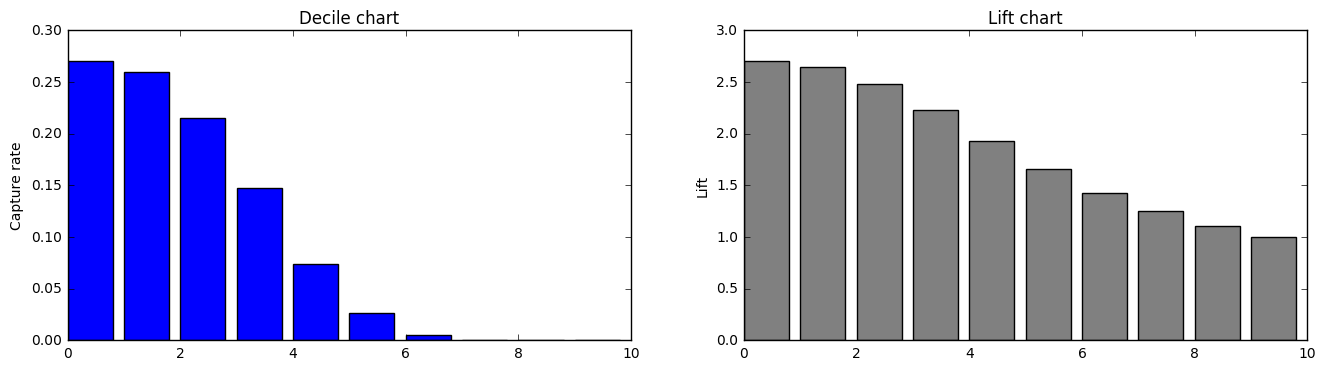

In [83]:
# Top decile, 5% capture, decile chart and lift chart
per5 = int(prob['Target'].shape[0]/20)
per5_1_rr = float(prob['Target'][0:per5].sum()/float(per5))
per5_1_cr = float(prob['Target'][0:per5].sum()/float(prob['Target'].sum()))

print 'Probability from classifier for Train' 
print 'Response 10%: ' + str(dec_1_rr)
print 'Capture at 10%: ' + str(dec_1_cr)
print 'Response 5%: ' + str(per5_1_rr)
print 'Capture at 5%: ' + str(per5_1_cr)

# print decile chart and lift chart
f, axs = plt.subplots(1,2,figsize=(16,4))
axs[0].bar(xrange(0,10), df['1st decile capture_rate'], color = 'blue'), axs[0].set_title('Decile chart')
axs[0].set_ylabel('Capture rate')
axs[1].bar(xrange(0,10), df['Lift'], color = 'grey'), axs[1].set_title('Lift chart'), axs[1].set_ylabel('Lift')

## Decile Info - Validation

In [84]:
# Validation AUC
val_pred_xgb_log2b = xgb_log2b.predict_proba(X_val)
print('Validation AUC: ' + str(roc_auc_score(Y_val, val_pred_xgb_log2b[:,1])))
print('Validation Log Loss: ' + str(log_loss(Y_val, val_pred_xgb_log2b[:,1])))

Validation AUC: 0.924260865821
Validation Log Loss: 0.33003275054


In [85]:
# Decile related info
df_list = [1,2,3,4,5,6,7,8,9,10]

prob = pd.DataFrame(val_pred_xgb_log2b[:,1]) 
prob.columns = ['Probability']
prob["Target"] = Y_val.values 
prob = prob.sort_values(by='Probability', ascending=0)

dec = int(prob['Target'].shape[0]/10)

for i in [0,1,2,3,4,5,6,7,8,9]:
    vars()['dec_'+str(df_list[i])+'_rr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(dec))
    vars()['dec_'+str(df_list[i])+'_cr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(prob['Target'].sum()))
    vars()['dec_'+str(df_list[i])+'_goods'] = float(prob['Target'][i*dec:(i+1)*dec].sum())
    vars()['dec_'+str(df_list[i])+'_bads'] = float(prob['Target'][i*dec:(i+1)*dec].count())-float(
        prob['Target'][i*dec:(i+1)*dec].sum())

decile_num = pd.DataFrame([dec, dec, dec, dec, dec, dec, dec, dec, dec, dec], columns = ['# decile'])
decile_goods = pd.DataFrame([dec_1_goods, dec_2_goods, dec_3_goods, dec_4_goods, dec_5_goods, dec_6_goods, dec_7_goods,
                          dec_8_goods, dec_9_goods, dec_10_goods], columns = ['# of goods'])
decile_bads = pd.DataFrame([dec_1_bads, dec_2_bads, dec_3_bads, dec_4_bads, dec_5_bads, dec_6_bads, dec_7_bads,
                          dec_8_bads, dec_9_bads, dec_10_bads], columns = ['# of bads'])
decile_cr = pd.DataFrame([dec_1_cr, dec_2_cr, dec_3_cr, dec_4_cr, dec_5_cr, dec_6_cr, dec_7_cr,
                          dec_8_cr, dec_9_cr, dec_10_cr], columns = ['1st decile capture_rate'])
decile_rr = pd.DataFrame([dec_1_rr, dec_2_rr, dec_3_rr, dec_4_rr, dec_5_rr, dec_6_rr, dec_7_rr,
                          dec_8_rr, dec_9_rr, dec_10_rr], columns = ['1st decile response_rate'])

In [86]:
# Decile info dataframe
df = [decile_num, decile_goods, decile_bads, decile_cr, decile_rr]
df = pd.concat(df, axis=1)
df['% of bads'] = df['# of bads']/df['# of bads'].sum()
df['% cum_goods'] = df['1st decile capture_rate'].cumsum()
df['% cum_bads'] = df['% of bads'].cumsum()
df['KS'] = (df['% cum_goods']-df['% cum_bads']).max()
df['Lift'] = df['% cum_goods']/(df['# decile']/prob['Target'].shape[0]).cumsum()
df

,# decile,# of goods,# of bads,1st decile capture_rate,1st decile response_rate,% of bads,% cum_goods,% cum_bads,KS,Lift
0,8085,8011.0,74.0,0.269912,0.990847,0.001446,0.269912,0.001446,0.671618,2.699391
1,8085,7166.0,919.0,0.241442,0.886333,0.017960,0.511354,0.019406,0.671618,2.557025
2,8085,5529.0,2556.0,0.186287,0.683859,0.049951,0.697642,0.069357,0.671618,2.325702
3,8085,3782.0,4303.0,0.127426,0.467780,0.084092,0.825067,0.153449,0.671618,2.062873
4,8085,2524.0,5561.0,0.085040,0.312183,0.108677,0.910108,0.262126,0.671618,1.820396
5,8085,1570.0,6515.0,0.052898,0.194187,0.127321,0.963005,0.389447,0.671618,1.605168
6,8085,726.0,7359.0,0.024461,0.089796,0.143815,0.987466,0.533262,0.671618,1.410806
7,8085,312.0,7773.0,0.010512,0.038590,0.151905,0.997978,0.685167,0.671618,1.247596
8,8085,58.0,8027.0,0.001954,0.007174,0.156869,0.999933,0.842036,0.671618,1.111146
9,8085,2.0,8083.0,0.000067,0.000247,0.157964,1.000000,1.000000,0.671618,1.000099


Probability from classifier for Validation
Response 10%: 0.99084724799
Capture at 10%: 0.269912398922
Response 5%: 0.998268184067
Capture at 5%: 0.135950134771


(<Container object of 10 artists>,
 <matplotlib.text.Text at 0x7f9b50a8a790>)

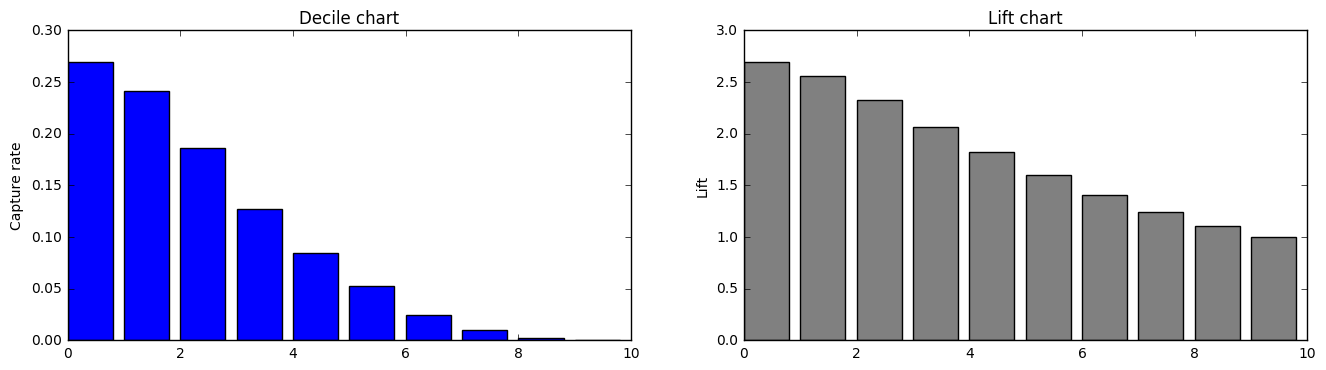

In [87]:
# Top decile, 5% capture, decile chart and lift chart

per5 = int(prob['Target'].shape[0]/20)
per5_1_rr = float(prob['Target'][0:per5].sum()/float(per5))
per5_1_cr = float(prob['Target'][0:per5].sum()/float(prob['Target'].sum()))

print 'Probability from classifier for Validation'
print 'Response 10%: ' + str(dec_1_rr)
print 'Capture at 10%: ' + str(dec_1_cr)
print 'Response 5%: ' + str(per5_1_rr)
print 'Capture at 5%: ' + str(per5_1_cr)

# print decile chart and lift chart
f, axs = plt.subplots(1,2,figsize=(16,4))
axs[0].bar(xrange(0,10), df['1st decile capture_rate'], color = 'blue'), axs[0].set_title('Decile chart')
axs[0].set_ylabel('Capture rate')
axs[1].bar(xrange(0,10), df['Lift'], color = 'grey'), axs[1].set_title('Lift chart'), axs[1].set_ylabel('Lift')

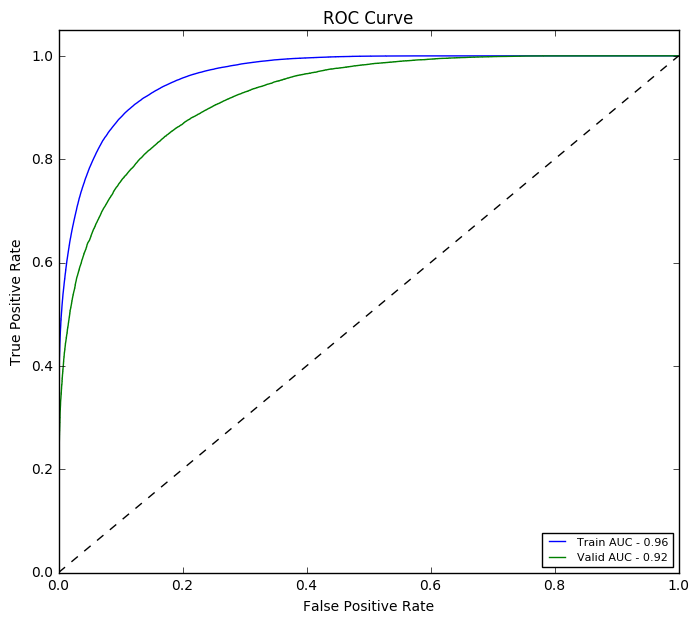

In [88]:
# Make ROC curve for train and validation as of now
from sklearn.metrics import roc_curve, auc

fpr_trn, tpr_trn, _= roc_curve(Y_train, y_predS_xgb_log2b[:,1])
fpr_tst, tpr_tst, _= roc_curve(Y_val, val_pred_xgb_log2b[:, 1]) 

roc_auc_trn = auc(fpr_trn, tpr_trn)
roc_auc_tst = auc(fpr_tst, tpr_tst)
# print roc_auc

# Plot of a ROC curve
plt.figure(figsize=(8,7))
plt.plot(fpr_trn, tpr_trn, label='Train AUC - %0.2f' % roc_auc_trn)
plt.plot(fpr_tst, tpr_tst, label='Valid AUC - %0.2f' % roc_auc_tst)   # Valid or Test ???
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={'size':8})
# plt.savefig('ROC_Curve.png')

In [89]:
feat_imp = pd.Series(xgb_log2b.booster().get_fscore()).sort_values(ascending=False)
feat_imp =pd.DataFrame({'features': feat_imp.index, 'importance' : feat_imp.values})
feat_imp['importance_percent']  = feat_imp['importance']/feat_imp['importance'].sum()

In [90]:
feat_imp.iloc[0:21]

,features,importance,importance_percent
0,kurt_que1,9447,0.055382
1,kurt_que2,9345,0.054784
2,canberra_val,8843,0.051841
3,cityblock_val,7993,0.046858
4,q1_form_char,7871,0.046143
5,q_ratio,7799,0.045721
6,q2_form_char,7496,0.043944
7,partial_ratio,7350,0.043089
8,skew_que1,7257,0.042543
9,skew_que2,7009,0.041089


In [91]:
def draw_feature_importance(fea_imp_df, nb, imp_col):
    fea_imp_df = fea_imp_df.sort_values(imp_col).reset_index(drop=True)
    fea_imp_df = fea_imp_df[-1*nb:].reset_index(drop=True)

    plt.figure(figsize=(10, nb*0.3))
    plt.title("Top %d Most Important Features"%nb)
    plt.barh(fea_imp_df.index, fea_imp_df[imp_col], color='#348ABD', align="center", lw='2', edgecolor='#348ABD', alpha=0.6)
    plt.yticks(fea_imp_df.index, fea_imp_df['features'], fontsize=12,)
    plt.ylim([-1, nb])
    plt.xlim([0, fea_imp_df[imp_col].max()*1.1])
    plt.show()

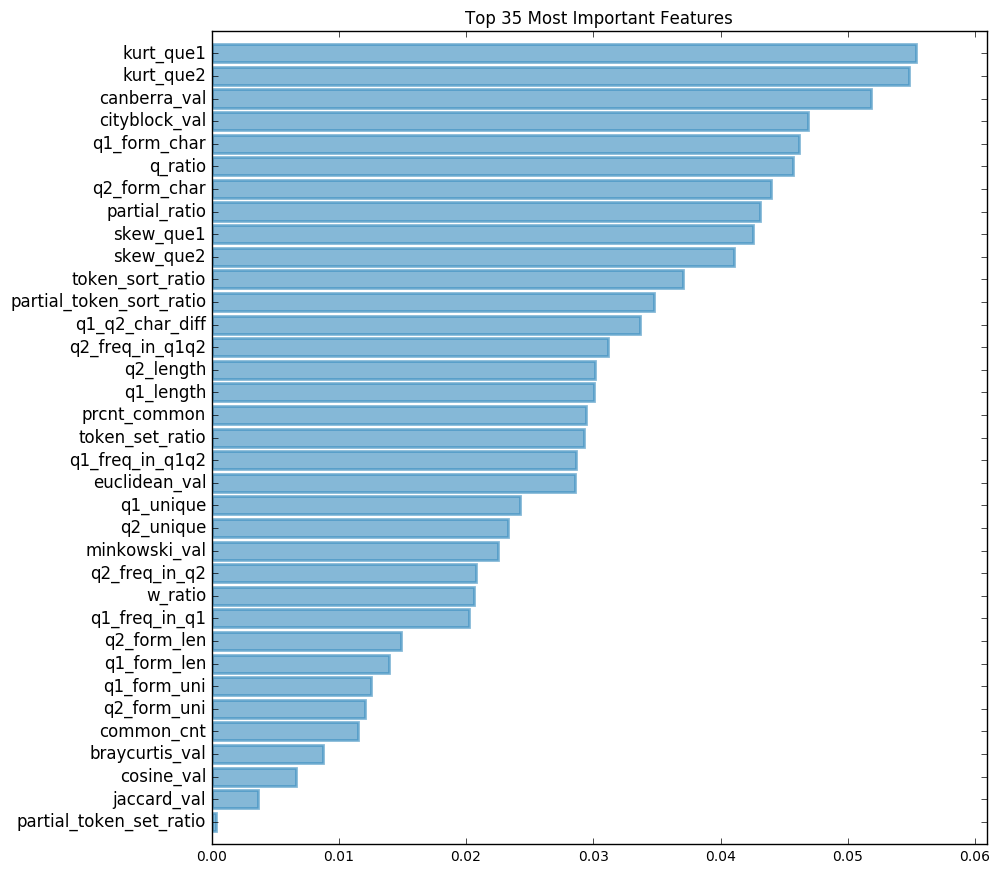

In [92]:
draw_feature_importance(feat_imp, feat_imp.shape[0], 'importance_percent')

In [93]:
# RUNNING THE FINAL SELECTED MODEL HYPERPARAMS ON THE FULL TRAINING DATASET

In [94]:
# xgboost fn
def modelfit2(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=val_dup[[0]].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics=['logloss'], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(dtrain[predictors], np.ravel(val_dup),eval_metric='logloss')     #Fit algorithm

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    print("AUC Score (Train): %f" % roc_auc_score(np.ravel(val_dup), dtrain_predprob))
    print("LogLoss Score (Train): %f" % log_loss(np.ravel(val_dup), dtrain_predprob))
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
# Model on Param8   : /home/pgoyal/quora/model4/xgb_dup_logloss.pkl
#xgb_log3 = XGBClassifier( max_depth= 7, min_child_weight= 1, gamma=0.0, colsample_bytree=0.6, subsample=0.9, 
#                    reg_alpha = 1, reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 1, learning_rate = 0.05, 
#                    n_estimators=800, objective= 'binary:logistic', nthread=4, seed=45)
#AUC Score (Train): 0.941038
#LogLoss Score (Train): 0.297366

#Validation AUC: 0.941038062532
#Validation Log Loss: 0.297365662032

#mean auc: 0.922951521568
#std auc: 0.000815248100667
#mean log_loss: -0.3330972847
#std log_loss: 0.00159704929804

Will train until cv error hasn't decreased in 50 rounds.


AUC Score (Train): 0.962640
LogLoss Score (Train): 0.252264


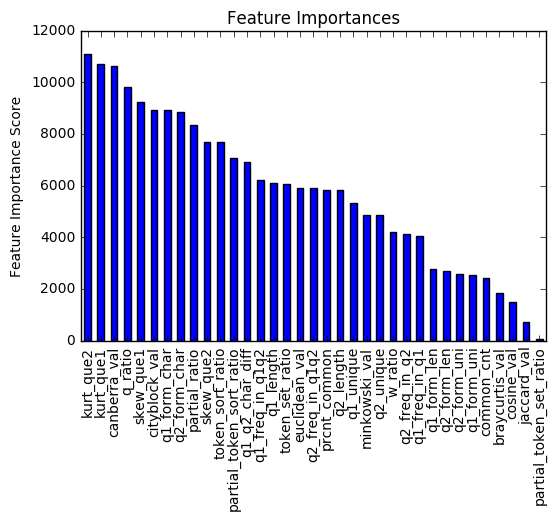

In [95]:
# Using the final model on the initial given full training dataset

# Model on Param9
xgb_log3 = XGBClassifier(max_depth= 9, min_child_weight= 1, gamma=0.0, colsample_bytree=0.6, subsample=0.9, 
                    reg_alpha = 1, reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 1, learning_rate = 0.05, 
                    n_estimators=750, objective= 'binary:logistic', nthread=4, seed=45)

# Choose the predictors for xgboost and fit the model
# predictors  = list(train_final.columns)
modelfit2(xgb_log3, train_final, predictors)

In [96]:
# Train roc auc
y_predS_final = xgb_log3.predict_proba(train_final)
print('Validation AUC: ' + str(roc_auc_score(val_dup, y_predS_final[:,1]) ))
print('Validation Log Loss: ' + str(log_loss(val_dup, y_predS_final[:,1]) ))

Validation AUC: 0.962640325867
Validation Log Loss: 0.25226441118


In [97]:
# Save the model
from sklearn.externals import joblib
# Model on param9
joblib.dump(xgb_log3, '/home/pgoyal/quora/model4/xgb_log3_dup_logloss.pkl')
# Model on param8
#joblib.dump(xgb_log3, '/home/pgoyal/quora/model4/xgb_dup_logloss.pkl')

['/home/pgoyal/quora/model4/xgb_log3_dup_logloss.pkl',
 '/home/pgoyal/quora/model4/xgb_log3_dup_logloss.pkl_01.npy']

In [ ]:
# Model with param8
#mean auc: 0.922951521568
#std auc: 0.000815248100667
#mean log_loss: -0.3330972847
#std log_loss: 0.00159704929804

In [99]:
# Model with param9
# Cross validation AUC & LogLoss
cv_score_final = cross_val_score(xgb_log3, train_final, np.ravel(val_dup), cv = 5, scoring ='roc_auc')
print('mean auc: ' + str(cv_score_final.mean()))
print('std auc: ' + str(cv_score_final.std()))
cv_score1_final = cross_val_score(xgb_log3, train_final, np.ravel(val_dup), cv = 5, scoring ='log_loss')
print 'mean log_loss: ' + str(cv_score1_final.mean())
print 'std log_loss: ' + str(cv_score1_final.std())

mean auc: 0.923886714964
std auc: 0.000641518417854
mean log_loss: -0.331000565633
std log_loss: 0.00139200038974
